In [1]:
%matplotlib inline
import os
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import time
import jax
import genjax
from genjax import grasp
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
import logging
import os

from jax import jit, lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
from numpyro import optim
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, RenyiELBO
from numpyro.handlers import replay, trace, seed
from optax import adam, sgd

# the only pyro dependency
import pyro.contrib.examples.multi_mnist as multi_mnist

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
label_fontsize = 70  # Set the desired font size here

## Model

In [2]:
def model():
    x = numpyro.sample("x", dist.Normal(0.0, 10.0))
    y = numpyro.sample("y", dist.Normal(0.0, 10.0))
    rs = x**2 + y**2
    z = numpyro.sample("z", dist.Normal(rs, 0.1 + (rs / 100.0)))
    return (x, y, z)


from numpyro.infer import Predictive

# Number of samples to draw
num_samples = 5000

# Create a predictive instance for prior sampling
predictive = Predictive(model, num_samples=num_samples)

# Draw samples (we don't need to provide data because we're sampling from the prior)
prior_samples = predictive(jax.random.PRNGKey(0))

In [3]:
x = prior_samples["x"]
y = prior_samples["y"]
z = prior_samples["z"]

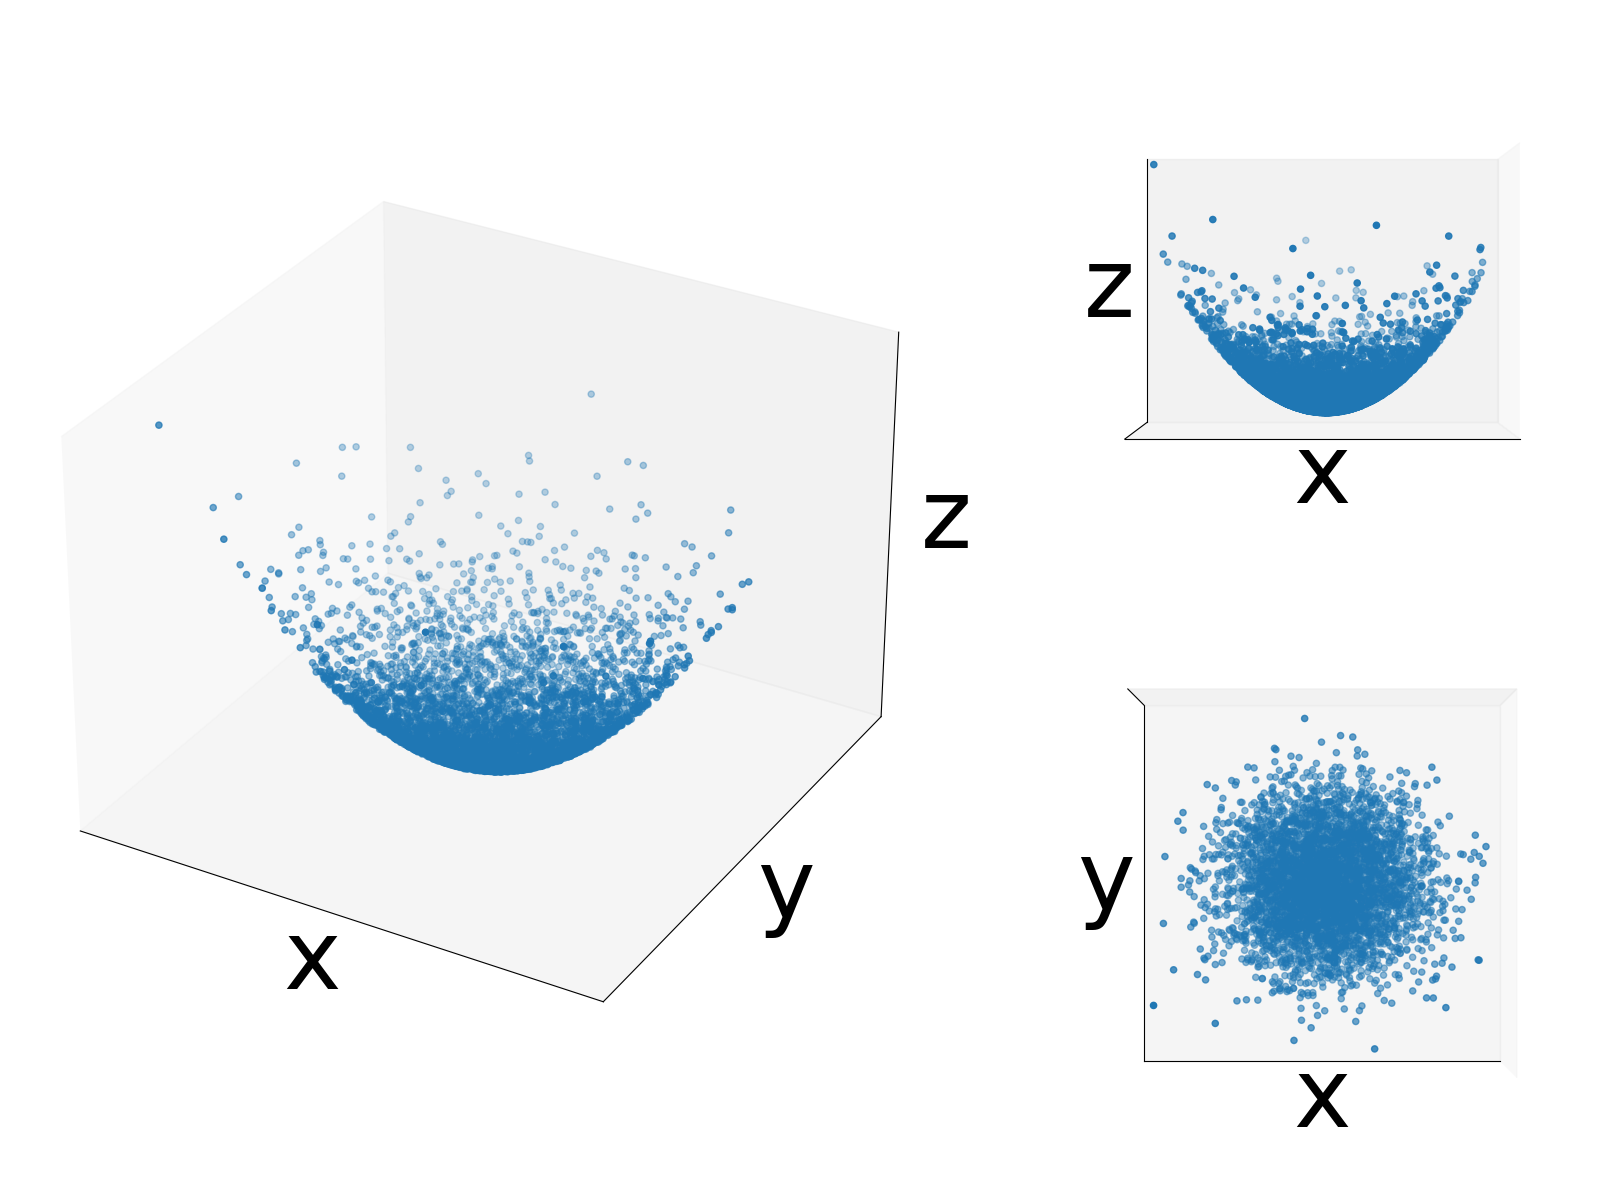

In [4]:
# Create a new figure
fig = plt.figure(figsize=(18, 12))  # Adjust the size for better visualization

gs = GridSpec(2, 2, height_ratios=[1, 1])

# First subplot - Original 3D plot
ax1 = fig.add_subplot(gs[:, 0], projection="3d")  # This spans both columns
ax1.scatter(x, y, z)
ax1.set_xlabel("x", fontsize=label_fontsize)
ax1.set_ylabel("y", fontsize=label_fontsize)
ax1.set_zlabel("z", fontsize=label_fontsize)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

# Second subplot - Rotated 3D plot looking at the XZ plane
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
ax2.scatter(x, y, z)
ax2.set_xlabel("x", fontsize=label_fontsize)
ax2.set_zlabel("z", fontsize=label_fontsize)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.view_init(elev=0, azim=-90)

# Third subplot - Rotated 3D plot looking at the XZ plane
ax3 = fig.add_subplot(gs[1, 1], projection="3d")
ax3.scatter(x, y, z)
ax3.set_xlabel("x", fontsize=label_fontsize)
ax3.set_ylabel("y", fontsize=label_fontsize)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])
ax3.view_init(elev=90, azim=-90)


# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area

plt.show()

In [5]:
def model(data):
    x = numpyro.sample("x", dist.Normal(0.0, 10.0))
    y = numpyro.sample("y", dist.Normal(0.0, 10.0))
    rs = x**2 + y**2
    z = numpyro.sample("z", dist.Normal(rs, 0.1 + (rs / 100.0)), obs=data)
    return (x, y, z)

## Naive variational guide

In [6]:
# Now, we define our variational proposal.
def guide(data):
    μ1 = numpyro.param("μ1", 0.0)
    μ2 = numpyro.param("μ2", 0.0)
    log_σ1 = numpyro.param("log_sigma1", 0.0)
    log_σ2 = numpyro.param("log_sigma2", 0.0)
    x = numpyro.sample("x", dist.Normal(μ1, jnp.exp(log_σ1)))
    y = numpyro.sample("y", dist.Normal(μ2, jnp.exp(log_σ2)))

## Training

In [7]:
svi = SVI(model, guide, sgd(1e-3), loss=TraceGraph_ELBO(num_particles=64))
key, sub_key = jax.random.split(key)
svi_result = svi.run(sub_key, 20000, 5.0)
params = svi_result.params
params

100%|█| 20000/20000 [00:03<00:00, 6373.65it/s, init loss: 450.7343, avg. loss [19001-20000]: 8.08



{
    'log_sigma1': Array(-1.2718312, dtype=float32),
    'log_sigma2': Array(-3.3849204, dtype=float32),
    'μ1': Array(-0.00073918, dtype=float32),
    'μ2': Array(-2.2133138, dtype=float32)
}

In [12]:
(svi_result.losses[1000:].mean(), svi_result.losses[1000:].std())

(Array(7.7814636, dtype=float32), Array(1.6878767, dtype=float32))

## Training (IWAE)

In [14]:
svi = SVI(model, guide, sgd(1e-3), loss=RenyiELBO(num_particles=5))
key, sub_key = jax.random.split(key)
svi_result = svi.run(sub_key, 20000, 5.0)
params = svi_result.params
params

100%|█| 20000/20000 [00:03<00:00, 6093.53it/s, init loss: 295.9826, avg. loss [19001-20000]: 7.76



{
    'log_sigma1': Array(-0.4948508, dtype=float32),
    'log_sigma2': Array(-2.392147, dtype=float32),
    'μ1': Array(0.06464732, dtype=float32),
    'μ2': Array(2.2078855, dtype=float32)
}

In [15]:
(svi_result.losses[1000:].mean(), svi_result.losses[1000:].std())

(Array(7.7716017, dtype=float32), Array(1.6447988, dtype=float32))